<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_Random_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the database and installing the necessary libraries

In [2]:
!pip install yfinance

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



### Load Data

In [12]:
# Carregar os dados do Bitcoin
ticker = 'BTC-USD'
start_date = '2007-03-18'
end_date = '2025-03-18'

data = yf.download(ticker, start=start_date, end=end_date)
data = data['Close']

[*********************100%***********************]  1 of 1 completed


### Train / Test

In [13]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]



### Random Walk

In [14]:
# Modelo Random Walk: as previsões são o valor anterior para o próximo período
predictions = test.shift(1)  # A previsão de t+1 é o valor de t

# Alinhar os dados de teste e as previsões
test_aligned = test[1:]  # Remove o primeiro valor do teste, que não tem previsão
predictions_aligned = predictions[1:]  # Remove o primeiro valor das previsões


### Métricas de Avaliação

In [15]:
# Cálculo das métricas de avaliação
mse = mean_squared_error(test_aligned, predictions_aligned)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_aligned, predictions_aligned)
r2 = r2_score(test_aligned, predictions_aligned)

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((test_aligned - predictions_aligned) / test_aligned)) * 100

# Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
smape = np.mean(2 * np.abs(test_aligned - predictions_aligned) /
                 (np.abs(test_aligned) + np.abs(predictions_aligned))) * 100

# Exibir as métricas
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")
print(f"SMAPE: {smape}")




MSE: 2511596.7097316873
RMSE: 1584.8017887835965
MAE: 1014.7027884301566
R²: 0.9958202181493964
MAPE: 1.8017072202157318
SMAPE: 1.8069989595940892


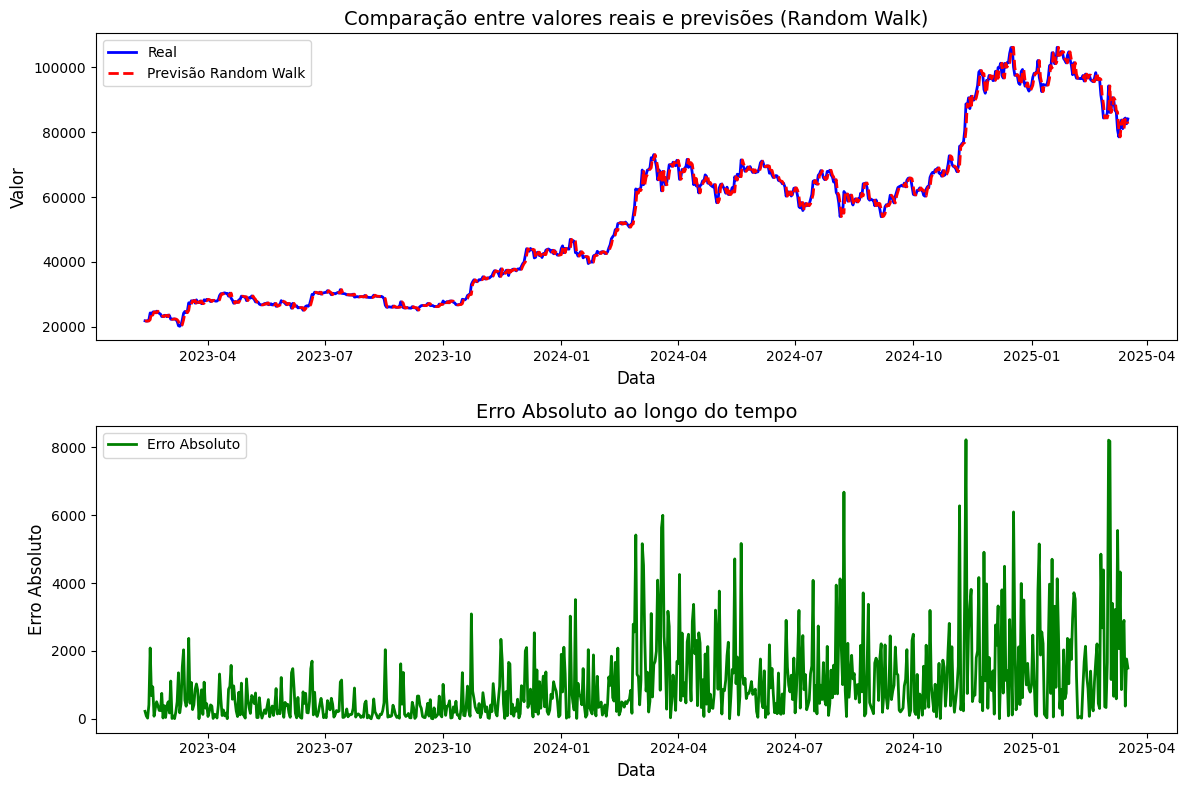

In [16]:
# Criar gráficos para avaliação
plt.figure(figsize=(12, 8))

# Gráfico 1: Comparação entre os valores reais e previsões
plt.subplot(2, 1, 1)
plt.plot(test_aligned.index, test_aligned, label="Real", color='blue', linewidth=2)
plt.plot(test_aligned.index, predictions_aligned, label="Previsão Random Walk", color='red', linestyle='--', linewidth=2)
plt.legend()
plt.title("Comparação entre valores reais e previsões (Random Walk)", fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valor', fontsize=12)

# Gráfico 2: Erro absoluto ao longo do tempo
plt.subplot(2, 1, 2)
plt.plot(test_aligned.index, np.abs(test_aligned - predictions_aligned), label="Erro Absoluto", color='green', linewidth=2)
plt.legend()
plt.title("Erro Absoluto ao longo do tempo", fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Erro Absoluto', fontsize=12)

plt.tight_layout()
plt.show()



## Gráfico de Resíduos

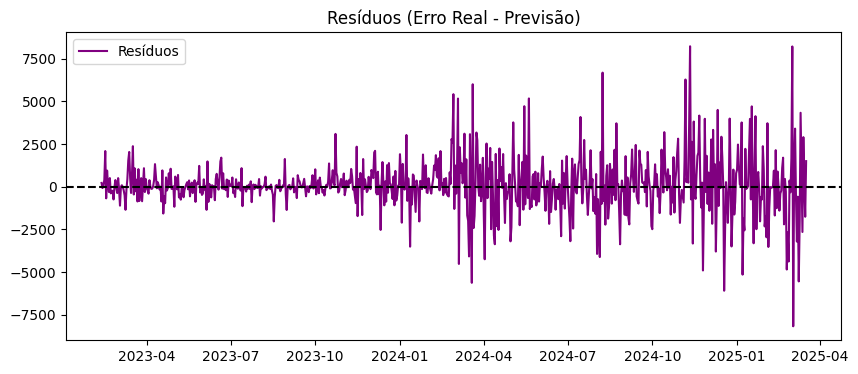

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(test_aligned.index, test_aligned - predictions_aligned, label="Resíduos", color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("Resíduos (Erro Real - Previsão)")
plt.show()


### Distribuição dos Resíduos (Histograma + KDE)

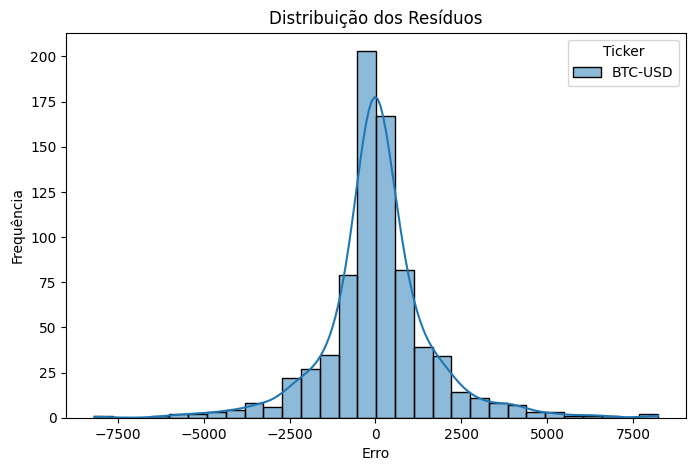

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot((test_aligned - predictions_aligned), kde=True, color='purple', bins=30)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.show()


### Gráfico de Autocorrelação dos Resíduos

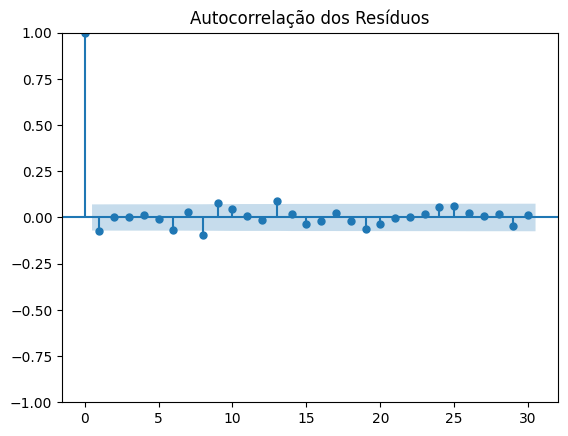

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(test_aligned - predictions_aligned, lags=30)
plt.title("Autocorrelação dos Resíduos")
plt.show()


### Boxplot dos Erros

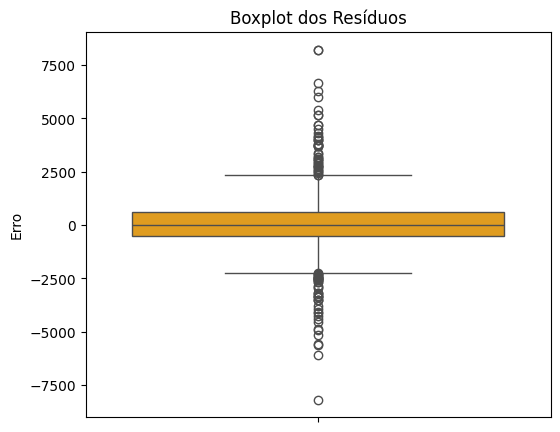

In [20]:
plt.figure(figsize=(6, 5))
sns.boxplot(y=(test_aligned.values.ravel() - predictions_aligned.values.ravel()), color='orange')
plt.title("Boxplot dos Resíduos")
plt.ylabel("Erro")
plt.show()
